In [9]:
import argparse
import math
import os.path
import time

import numpy as np

from pydrake.all import (VectorSystem, MathematicalProgram)

from underactuated import ManipulatorDynamics

class Ramone2dController(VectorSystem):
    
    def __init__(self, ramone, 
        desired_goal = 0.0, 
        print_period = 0.0):
        '''
        Controls a planar RAMone described
        in ramone.urdf.

        :param ramone: A pydrake RigidBodyTree() loaded
            from ramone.urdf.
        :param desired_goal: The goal for the model to reach
        :param print_period: If nonzero, this controller will print to
            the python console every print_period (simulated) seconds
            to indicate simulation progress.
        '''
        VectorSystem.__init__(self,
            12, # 12 inputs: x, z, alpha_l, beta_l, alpha_r, beta_r, and their derivatives
            4)  # Torque on hip, and on knee for the two legs left and right

        self.ramone = ramone
        self.desired_goal = desired_goal
        self.print_period = print_period
        self.last_print_time = -print_period

        # The index of the left foot and the right foot
        self.left_foot_index = ramone.FindBody("left_foot").get_body_index()
        self.right_foot_index = ramone.FindBody("right_foot").get_body_index()

        # Default parameters for the ramone
#         self.left_foot_x = 0
#         self.right_foot_x = 0
#         self.com_x = 0
#         self.X = np.zeros(12)
        self.left_contact = False
        self.right_contact = False
        
        # Current phase
        self.isLeft = True
        self.err = 0
        self.up = True
        self.down = False


    def WalkingHipTorque(self, X):
        '''
        Given the system state X,
            returns a tuple of float of the hip torque on 
            the left and the right foot
        
        :param X: numpy array, length 12, full state of the ramone.

        :return: a tuple of float, the desired hip torque act on 
                the left and the right foot
        '''
        # Unpack state
        x, z, alpha_l, beta_l, alpha_r, beta_r = X[0:6]
        xd, zd, alpha_ld, beta_ld, alpha_rd, beta_rd = X[6:12]
        
        kinsol = self.ramone.doKinematics(X)
        foot_point = np.array([0.0, 0.0, 0.0])
        
        # Check left foot contact
        left_foot_in_world = self.ramone.transformPoints(kinsol, foot_point, self.left_foot_index, 0).flatten()
        left_contact = left_foot_in_world[2] <= -2.5
        
        # Check right foot contact
        right_foot_in_world = self.ramone.transformPoints(kinsol, foot_point, self.right_foot_index, 0).flatten()
        right_contact = right_foot_in_world[2] <= -2.5
        
        # Center of mass
        com = self.ramone.centerOfMass(kinsol, set([0]))
        
#         self.com_x = com[0]
#         self.left_foot_x = left_foot_in_world[0]
#         self.right_foot_x = right_foot_in_world[0]
        self.left_contact = left_contact
        self.right_contact = right_contact
        
        kp1 = 10; kd1 = 2
        hip_l = 0; hip_r = 0
        
        ### Walking controller
        desired_dist = 0.3
        desired_alpha = - np.pi/6
        if self.isLeft:
            err = right_foot_in_world[0] - left_foot_in_world[0]
            self.err = err
            if err < desired_dist:
                hip_l = - kp1 * (err - desired_dist) - kd1 * alpha_ld
                if zd < 0:
                    hip_r = + kp1 * (err - desired_dist) - kd1 * alpha_rd
                else:
                    hip_r = - kp1 * (alpha_r - desired_alpha) - kd1 * alpha_rd
            else:
                if right_contact:
                    self.isLeft = False
        else:
            err = left_foot_in_world[0] - right_foot_in_world[0]
            self.err = err
            if err < desired_dist:
                hip_r = - kp1 * (err - desired_dist) - kd1 * alpha_rd
                if zd < 0:
                    hip_l = + kp1 * (err - desired_dist) - kd1 * alpha_ld
                else:
                    hip_l = - kp1 * (alpha_l -  desired_alpha) - kd1 * alpha_ld
            else:
                if left_contact:
                    self.isLeft = True
                
        return (hip_l, hip_r)

    def WalkingKneeTorque(self, X):
        '''
        Given the system state X,
            returns a tuple of float of the hip torque on 
            the left and the right foot
        
        :param X: numpy array, length 12, full state of the ramone.

        :return: a tuple of float, the desired knee torque act on 
                the left and the right foot
        '''
        # Unpack state
        x, z, alpha_l, beta_l, alpha_r, beta_r = X[0:6]
        xd, zd, alpha_ld, beta_ld, alpha_rd, beta_rd = X[6:12]
        
        kinsol = self.ramone.doKinematics(X)
        foot_point = np.array([0.0, 0.0, 0.0])
        
        # Check left foot contact
        left_foot_in_world = self.ramone.transformPoints(kinsol, foot_point, self.left_foot_index, 0).flatten()
        left_contact = left_foot_in_world[2] <= -2.5
        
        # Check right foot contact
        right_foot_in_world = self.ramone.transformPoints(kinsol, foot_point, self.right_foot_index, 0).flatten()
        right_contact = right_foot_in_world[2] <= -2.5
        
        # Center of mass
        com = self.ramone.centerOfMass(kinsol, set([0]))
        
#         self.left_foot_x = left_foot_in_world[0]
#         self.right_foot_x = right_foot_in_world[0]
#         self.left_contact = left_contact
#         self.right_contact = right_contact

        knee_l = 0; knee_r = 0
                
        
        ### Walking controller
        kp1 = 20; kp2 = 20; kp3 = 5; kd = 1
        
        if self.isLeft:
            knee_r = - kp3 * (beta_r + alpha_r) - kd * beta_rd
            knee_l = - kp1 * (beta_l - 0) 
            
        else:
            knee_l = - kp3 * (beta_l + alpha_l) - kd * beta_ld
            knee_r = - kp1 * (beta_r - 0)
        
        return (knee_l, knee_r)
    
    
    def HoppingHipTorque(self, X):
        '''
        Given the system state X,
            returns a tuple of float of the hip torque on 
            the left and the right foot
        
        :param X: numpy array, length 12, full state of the ramone.

        :return: a tuple of float, the desired hip torque act on 
                the left and the right foot
        '''
        # Unpack state
        x, z, alpha_l, beta_l, alpha_r, beta_r = X[0:6]
        xd, zd, alpha_ld, beta_ld, alpha_rd, beta_rd = X[6:12]
        
        kinsol = self.ramone.doKinematics(X)
        foot_point = np.array([0.0, 0.0, 0.0])
        
        # Check left foot contact
        left_foot_in_world = self.ramone.transformPoints(kinsol, foot_point, self.left_foot_index, 0).flatten()
        left_contact = left_foot_in_world[2] <= -2.5
        
        # Check right foot contact
        right_foot_in_world = self.ramone.transformPoints(kinsol, foot_point, self.right_foot_index, 0).flatten()
        right_contact = right_foot_in_world[2] <= -2.5
        
        # Center of mass
        com = self.ramone.centerOfMass(kinsol, set([0]))
        
#         self.com_x = com[0]
#         self.left_foot_x = left_foot_in_world[0]
#         self.right_foot_x = right_foot_in_world[0]
        self.left_contact = left_contact
        self.right_contact = right_contact
        
        kp1 = 10; kp2 = 20; kd1 = 2
        hip_l = 0; hip_r = 0
        
        ### Hopping controller
        desired_alpha = - np.pi/6
        if self.isLeft:
            if zd < 0:
                if not self.down:
                    self.down = True
            else:
                if not self.up:
                    self.up = True
                    
            if self.up and self.down and not left_contact:
                self.isLeft = False
                self.up = False
                self.down = False
                
            hip_r = - kp1 * (alpha_r - desired_alpha) - kd1 * alpha_rd
            if not left_contact:
                hip_l = - kp1 * (alpha_l + beta_l/2) - kd1 * alpha_ld
            else:
                if beta_ld >= 0:
                    hip_l = - kp1 * (alpha_l + beta_l) - kd1 * alpha_ld
                else:
                    hip_l = - kp2 * (alpha_l - beta_l) - kd1 * alpha_ld
        else:
            if zd < 0:
                if not self.down:
                    self.down = True
            else:
                if not self.up:
                    self.up = True
                    
            if self.up and self.down and not right_contact:
                self.isLeft = True
                self.up = False
                self.down = False
                
            hip_l = - kp1 * (alpha_l - desired_alpha) - kd1 * alpha_ld
            if not right_contact:
                hip_r = - kp1 * (alpha_r + beta_r/2) - kd1 * alpha_rd
            else:
                if beta_rd >= 0:
                    hip_r = - kp1 * (alpha_r + beta_r) - kd1 * alpha_rd
                else:
                    hip_r = - kp2 * (alpha_r - beta_r) - kd1 * alpha_rd
                
        return (hip_l, hip_r)
#         return (0, 0)
    
    def HoppingKneeTorque(self, X):
        '''
        Given the system state X,
            returns a tuple of float of the hip torque on 
            the left and the right foot
        
        :param X: numpy array, length 12, full state of the ramone.

        :return: a tuple of float, the desired knee torque act on 
                the left and the right foot
        '''
        # Unpack state
        x, z, alpha_l, beta_l, alpha_r, beta_r = X[0:6]
        xd, zd, alpha_ld, beta_ld, alpha_rd, beta_rd = X[6:12]
        
        kinsol = self.ramone.doKinematics(X)
        foot_point = np.array([0.0, 0.0, 0.0])
        
        # Check left foot contact
        left_foot_in_world = self.ramone.transformPoints(kinsol, foot_point, self.left_foot_index, 0).flatten()
        left_contact = left_foot_in_world[2] <= -2.5
        
        # Check right foot contact
        right_foot_in_world = self.ramone.transformPoints(kinsol, foot_point, self.right_foot_index, 0).flatten()
        right_contact = right_foot_in_world[2] <= -2.5
        
        # Center of mass
        com = self.ramone.centerOfMass(kinsol, set([0]))
        
#         self.left_foot_x = left_foot_in_world[0]
#         self.right_foot_x = right_foot_in_world[0]
#         self.left_contact = left_contact
#         self.right_contact = right_contact

        knee_l = 0; knee_r = 0
                
        
        ### Hopping controller
        kp1 = 10; kp2 = 10; kp3 = 10; kd = 2
        desire_beta1 = np.pi/4; desire_beta2 = np.pi/2
        
        if self.isLeft:
            if not left_contact:
                knee_l = - kp1 * (beta_l - desire_beta1) - kd * beta_ld
                knee_r = - kp1 * (beta_r - desire_beta2) - kd * beta_rd
            else:
                if beta_ld >= 0:
                    knee_l = - kp3 * (beta_l - desire_beta1) - kd * beta_ld
                else:
                    knee_l = - kp2 * (beta_l - 0)
                knee_r = - kp1 * (beta_r - desire_beta2) - kd * beta_rd
        else:
            if not right_contact:
                knee_r = - kp1 * (beta_r - desire_beta1) - kd * beta_rd
                knee_l = - kp1 * (beta_l - desire_beta2) - kd * beta_ld
            else:
                if beta_rd >= 0:
                    knee_r = - kp3 * (beta_r - desire_beta1) - kd * beta_rd
                else:
                    knee_r = - kp2 * (beta_r - 0)
                knee_l = - kp1 * (beta_l - desire_beta2) - kd * beta_ld
        
        return (knee_l, knee_r)
#         return (0, 0)
        

    def _DoCalcVectorOutput(self, context, u, x, y):
        '''
        Given the state of the ramone (as the input to this system,
        u), populates (in-place) the control inputs to the ramone
        (y). This is given the state of this controller in x, but
        this controller has no state, so x is empty.

        :param u: numpy array, length 12, full state of the ramone.
        :param x: numpy array, length 0, full state of this controller.
        :output y: numpy array, length 4, control input to pass to the
            ramone.
        '''
#         hip_l, hip_r = self.WalkingHipTorque(X = u)
#         knee_l, knee_r = self.WalkingKneeTorque(X = u)

        hip_l, hip_r = self.HoppingHipTorque(X = u)
        knee_l, knee_r = self.HoppingKneeTorque(X = u)
        
        # Print the current time, if requested,
        # as an indicator of how far simulation has
        # progressed.
        if (self.print_period and
            context.get_time() - self.last_print_time >= self.print_period):
            print "t: ", context.get_time()
#             print "is Left Phase", self.isLeft
#             print "left: ", self.left_contact,"right: ", self.right_contact
#             print "err= ", self.err
#             print "left: ",self.left_foot_x, "right: ", self.right_foot_x, "com: ", self.com_x
#             print "left > com ", self.left_foot_x >= self.com_x
#             print "right > com ", self.right_foot_x >= self.com_x           
            print "hip_l= ", hip_l, "hip_r= ", hip_r, "knee_l= ", knee_l, "knee_r= ", knee_r
            print "x", u[0], "z", u[1], "alpha_l", u[2], "beta_l", u[3], "alpha_r", u[4],  "beta_r", u[5]
            
            self.last_print_time = context.get_time()

#         y[:] = [ hip_l, hip_r, knee_l, knee_r ]
        y[:] = [ hip_l, hip_r, knee_l, knee_r]
#         y[:] = [ hip_l, hip_r ]

In [10]:
import argparse
import math
import numpy as np

from pydrake.all import (Box,
                         DiagramBuilder,
                         FloatingBaseType,
                         Isometry3,
                         RigidBodyTree,
                         SignalLogger,
                         Simulator,
                         VisualElement)

from pydrake.all import AddModelInstanceFromUrdfFile, RigidBodyPlant, AddModelInstancesFromSdfString
from underactuated import (PlanarRigidBodyVisualizer)

def Simulate2dRamone(x0, duration,
        desired_goal = 0.0,
        print_period = 0.0):

    builder = DiagramBuilder()
    tree = RigidBodyTree()
    AddModelInstanceFromUrdfFile("ramone_act.urdf", FloatingBaseType.kRollPitchYaw, None, tree)

    plant = builder.AddSystem(RigidBodyPlant(tree))

    controller = builder.AddSystem(
        Ramone2dController(tree, 
                           desired_goal=desired_goal, 
                           print_period=print_period))

    builder.Connect(plant.get_output_port(0), controller.get_input_port(0))
    builder.Connect(controller.get_output_port(0), plant.get_input_port(0))

    state_log = builder.AddSystem(SignalLogger(plant.get_num_states()))
    builder.Connect(plant.get_output_port(0), state_log.get_input_port(0))

    diagram = builder.Build()
    simulator = Simulator(diagram)

    simulator.set_target_realtime_rate(1.0)
    simulator.set_publish_every_time_step(True)
    simulator.get_mutable_context().set_accuracy(1e-4)

    state = simulator.get_mutable_context().get_mutable_continuous_state_vector()

    state.SetFromVector(x0)

    simulator.StepTo(duration)

    return tree, controller, state_log, plant


In [25]:
import matplotlib.pyplot as plt
from IPython.display import HTML

x0 = np.zeros(12)
x0[0] = 0
x0[1] = 0
x0[2] = 0
x0[3] = 0
x0[4] = 0
x0[5] = 0


ramone, controller, state_log, plant = Simulate2dRamone(x0, 
                                                duration=3, 
                                                desired_goal = 5.0,
                                                print_period = 1.)
print "Done"


t:  0.0
hip_l=  -0.0 hip_r=  -5.23598775598 knee_l=  7.85398163397 knee_r=  15.7079632679
x 0.0 z 0.0 alpha_l 0.0 beta_l 0.0 alpha_r 0.0 beta_r 0.0
t:  1.00025790677
hip_l=  0.218278394346 hip_r=  -0.0158602930329 knee_l=  0.0915186108355 knee_r=  -0.0107350022942
x 0.177665820134 z -1.2481747542 alpha_l -0.533210210103 beta_l 1.30695095298 alpha_r -0.184522766099 beta_r 0.804968421781
t:  2.00028773395
hip_l=  -0.314222474509 hip_r=  -10.2564262488 knee_l=  -1.96735334676 knee_r=  -9.50163515044
x 1.67453037381 z -1.79757290539 alpha_l -0.524621870896 beta_l 1.52470929556 alpha_r -0.549646102485 beta_r 1.53167313811
Done


In [26]:
viz = PlanarRigidBodyVisualizer(ramone, xlim=[-2, 8], ylim=[-2.5, -1])
viz.fig.set_size_inches(10, 5)
ani = viz.animate(state_log, 30, repeat=True)
plt.close(viz.fig)
HTML(ani.to_html5_video()) # This needs to be the last line for the video to display

Spawning PlanarRigidBodyVisualizer for tree with 4 actuators


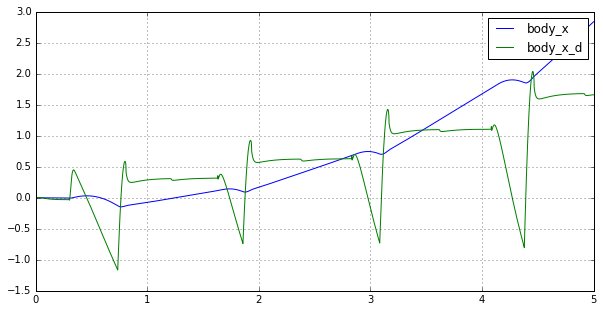

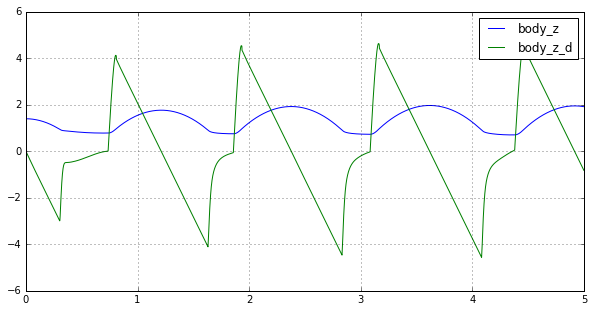

In [18]:
# Plot traces of certain states
plt.figure().set_size_inches(10, 5)
plt.plot(state_log.sample_times(), state_log.data()[0, :])
plt.plot(state_log.sample_times(), state_log.data()[0+6, :])
plt.grid(True)
plt.legend(["body_x", "body_x_d"])

plt.figure().set_size_inches(10, 5)
plt.plot(state_log.sample_times(), state_log.data()[1, :]+ 2.5*np.ones(166357)) #166072 492801
plt.plot(state_log.sample_times(), state_log.data()[1+6, :])
plt.grid(True)
plt.legend(["body_z", "body_z_d"])

In [19]:
state_log.data()[1,:] + 2.5*np.ones(166357)

array([ 1.4       ,  1.4       ,  1.4       , ...,  1.92135774,
        1.92031359,  1.91925271])